<a href="https://www.kaggle.com/code/mustafacihadgoktepe/chest-x-ray-images-pneumonia?scriptVersionId=108471639" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='binary')

val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/'

val_datagen = ImageDataGenerator(rescale=1/255)

val_generator =  val_datagen.flow_from_directory(val_dir,
                                                 batch_size=32,
                                                 class_mode='binary',
                                                 target_size=(150, 150))

test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                   batch_size=32,
                                                   class_mode='binary',
                                                   target_size=(150, 150))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [11]:
train_generator[0][0].shape

(32, 150, 150, 3)

In [12]:
train_generator[0][0][0].shape # image

(150, 150, 3)

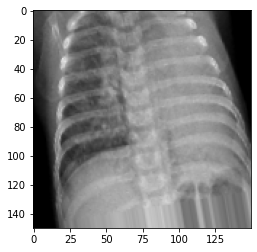

In [13]:
plt.imshow(train_generator[0][0][0]);

In [14]:
train_generator[0][1].shape

(32,)

In [15]:
train_generator[0][1][0] # label

1.0

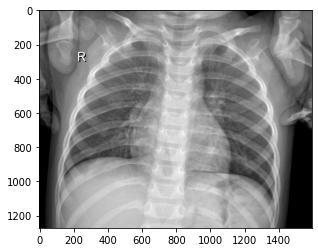

In [16]:
img_dir ='/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0219-0001.jpeg'

plt.imshow(plt.imread(img_dir), cmap='gray');

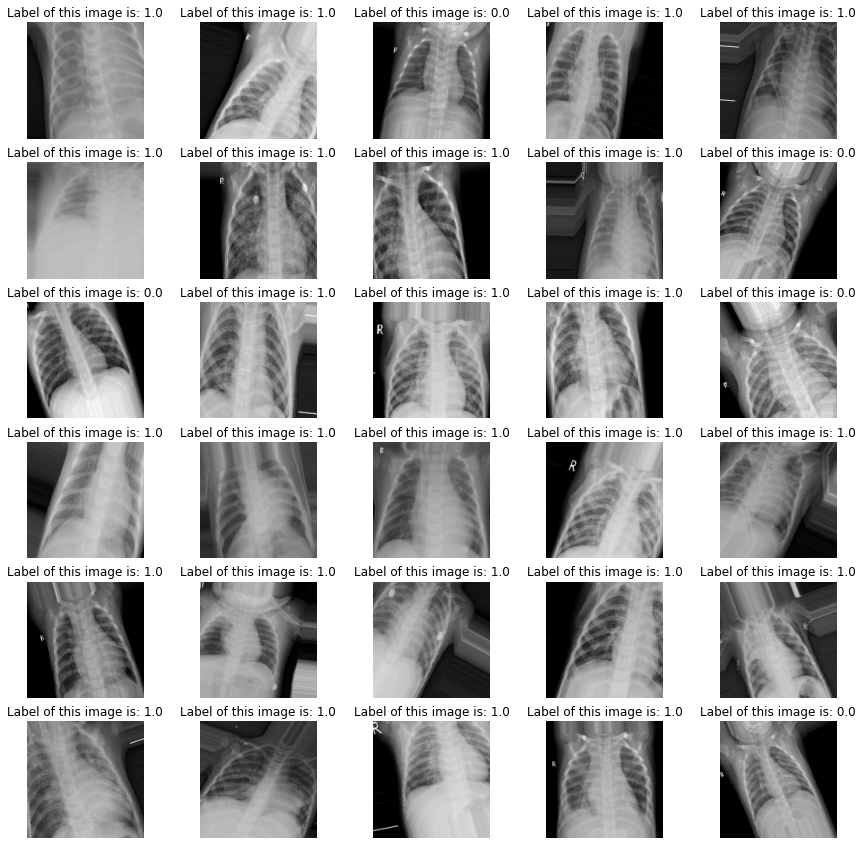

In [17]:
plt.figure(figsize=(15,15))
plt.tight_layout()

data = train_generator.next()
# image = data[0]
# label =data[1]

for i in range(30):
    plt.subplot(6,5,i+1)
    plt.axis('off')
    plt.title('Label of this image is: ' + str(data[1][i]))
    plt.imshow(data[0][i], cmap='gray')

In [18]:
from collections import Counter

counter = Counter(train_generator.classes)
counter

Counter({0: 1341, 1: 3875})

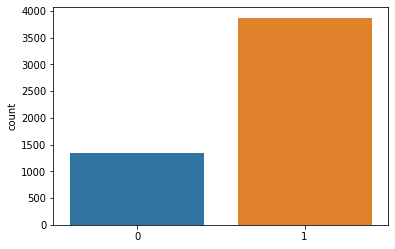

In [19]:
sns.countplot(train_generator.classes);

In [20]:
from tensorflow.keras import Sequential, layers, callbacks, metrics, optimizers, losses

model = Sequential([
    layers.BatchNormalization(input_shape=(150, 150, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Conv2D(128, (5,5), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
]) 

model.compile(optimizer=optimizers.Adam(),
              loss=losses.BinaryCrossentropy(),
              metrics=[metrics.BinaryAccuracy(),
                       metrics.AUC(),
                       metrics.Precision(),
                       metrics.Recall()])
              
early_stopping = callbacks.EarlyStopping(min_delta=0.001, patience=10, restore_best_weights=True)

lr_sch = callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience= 2, factor = np.sqrt(0.2), verbose = 1,
                                     min_lr = 5e-10)

model.summary()

2022-10-18 14:38:17.752500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 150, 150, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0

2022-10-18 14:38:17.928903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 14:38:17.929848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 14:38:17.931135: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 14:38:17.931475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [23]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes = np.unique(train_generator.classes),
                                                  y = train_generator.classes)

class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [24]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight = class_weights,
    callbacks=[early_stopping, lr_sch]
)

2022-10-18 14:38:57.998324: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-10-18 14:39:02.605047: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


163/163 [==============================] - 146s 830ms/step - loss: 0.3995 - binary_accuracy: 0.8146 - auc: 0.9112 - precision: 0.9474 - recall: 0.7946 - val_loss: 3.6869 - val_binary_accuracy: 0.5000 - val_auc: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/100
163/163 [==============================] - 98s 603ms/step - loss: 0.3029 - binary_accuracy: 0.8740 - auc: 0.9453 - precision: 0.9613 - recall: 0.8653 - val_loss: 3.4002 - val_binary_accuracy: 0.5000 - val_auc: 0.6250 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/100
163/163 [==============================] - 100s 612ms/step - loss: 0.2559 - binary_accuracy: 0.8892 - auc: 0.9597 - precision: 0.9674 - recall: 0.8805 - val_loss: 2.3866 - val_binary_accuracy: 0.5625 - val_auc: 0.5703 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 4/100
163/163 [==============================] - 99s 606ms/step - loss: 0.2461 - binary_accuracy: 0.9026 - auc: 0.9619 - precision: 0.9714 - recall: 0.8952 - val_loss: 2.1042 - val_b

In [34]:
history_df = pd.DataFrame(history.history)
history_df

,loss,binary_accuracy,auc,precision,recall,val_loss,val_binary_accuracy,val_auc,val_precision,val_recall,lr
0,0.399525,0.814609,0.911172,0.947385,0.794581,3.686864,0.5000,0.500000,0.500000,1.000,0.001000
1,0.302875,0.874041,0.945270,0.961296,0.865290,3.400242,0.5000,0.625000,0.500000,1.000,0.001000
2,0.255896,0.889187,0.959665,0.967394,0.880516,2.386613,0.5625,0.570312,0.533333,1.000,0.001000
3,0.246052,0.902607,0.961917,0.971437,0.895226,2.104235,0.5625,0.734375,1.000000,0.125,0.001000
4,0.244011,0.902416,0.962562,0.969064,0.897290,2.578561,0.5000,0.562500,0.000000,0.000,0.001000
5,0.227376,0.904333,0.967724,0.968368,0.900645,1.307688,0.5000,0.453125,0.500000,0.375,0.001000
6,0.230913,0.903183,0.967104,0.969883,0.897548,2.858540,0.5625,0.593750,0.533333,1.000,0.001000
7,0.221482,0.908934,0.969307,0.968836,0.906581,0.998029,0.6250,0.750000,0.571429,1.000,0.001000
8,0.208782,0.914877,0.971765,0.977191,0.906581,1.285377,0.4375,0.671875,0.000000,0.000,0.001000
9,0.194869,0.921012,0.975955,0.975818,0.916387,2.135728,0.5625,0.546875,0.533333,1.000,0.001000


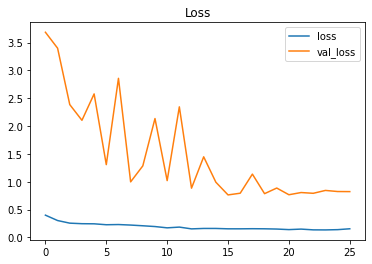

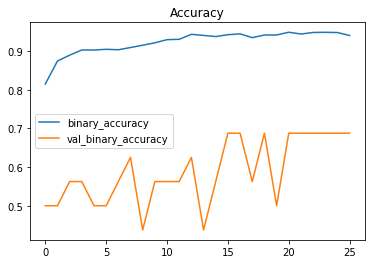

In [35]:
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss");
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy");


In [36]:
model.evaluate(test_generator)

20/20 [==============================] - 11s 546ms/step - loss: 0.2612 - binary_accuracy: 0.8958 - auc: 0.9588 - precision: 0.9265 - recall: 0.9051


[0.26122739911079407,
 0.8958333134651184,
 0.958810031414032,
 0.9265092015266418,
 0.9051281809806824]

In [38]:
preds = model.predict(test_generator)
preds[preds <= 0.5] = 0
preds[preds > 0.5] = 1
pd.DataFrame(preds, columns=['Predictions'])

,Predictions
0,1.0
1,0.0
2,1.0
3,1.0
4,0.0
...,...
619,1.0
620,1.0
621,1.0
622,1.0


In [23]:
test_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

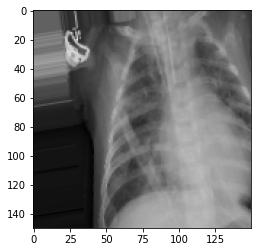

In [54]:
plt.imshow(train_generator[1][0][1]);

In [56]:
test = train_generator[1][0][1]
test = np.expand_dims(test, axis = 0)
pred_ = model.predict(test)
pred_

array([[0.99351877]], dtype=float32)

Thanks for reading.